<a href="https://colab.research.google.com/github/RyosukeHanaoka/flask_deploy/blob/main/ViT_crp1_0_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install vit_pytorch timm
from __future__ import print_function

import glob
import os
import random
import cv2
import shutil
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from vit_pytorch.efficient import ViT
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint

def split_and_move_files(src_dir, train_dest, val_dest, test_dest, split_ratio=(0.7, 0.2, 0.1)):
    all_files = glob.glob(f"{src_dir}/*")
    random.shuffle(all_files)

    train_split = int(split_ratio[0] * len(all_files))
    val_split = train_split + int(split_ratio[1] * len(all_files))

    for idx, file in enumerate(all_files):
        if idx < train_split:
            dest = train_dest
        elif idx < val_split:
            dest = val_dest
        else:
            dest = test_dest
        os.makedirs(dest, exist_ok=True)
        shutil.copy(file, os.path.join(dest, os.path.basename(file)))

src_dir_RA = '/content/drive/MyDrive/crp>1.0/image_crp1.0_patient'
train_dest_RA = '/content/train/RA_Right_Hand'
val_dest_RA = '/content/val/RA_Right_Hand'
test_dest_RA = '/content/test/RA_Right_Hand'

split_and_move_files(src_dir_RA, train_dest_RA, val_dest_RA, test_dest_RA)

src_dir_nonRA = '/content/drive/MyDrive/images_ra_and_nonra/image_nonra_patient'
train_dest_nonRA = '/content/train/nonRA_Right_Hand'
val_dest_nonRA = '/content/val/nonRA_Right_Hand'
test_dest_nonRA = '/content/test/nonRA_Right_Hand'

split_and_move_files(src_dir_nonRA, train_dest_nonRA, val_dest_nonRA, test_dest_nonRA)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 6.0 MB/s eta 0:00:00


In [10]:
batch_size=16 #バッチサイズ(batch size)
epochs = 120
lr = 1e-3#学習率(learning rate: lr)
gamma = 0.7#更新率。デフォルトは0.1。この場合、更新タイミングで学習率が1/10になる
seed = 42#乱数のシード。慣用的に42が使用されることが多い。
def seed_everything(seed):#使用するモジュールにおける乱数のシードを統一し、再現性を確保している。
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)#その他さまざまなtorchに含まれる非決定的な計算過程を決定的なものにして再現性を確保している
# GPUの設定
device = 'cuda'

from torchvision import transforms

# 前処理の定義
train_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15),
    # transforms.RandomVerticalFlip(),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    #transforms.RandomHorizontalFlip(),
    # transforms.RandomGrayscale(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError

# 画像のパス
train_dir = "/content/train"
val_dir = "/content/val"
test_dir = "/content/test"

class RobustImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super(RobustImageFolder, self).__getitem__(index)
        except UnidentifiedImageError:
            print(f"Couldn't read image at index {index}: UnidentifiedImageError")
            # 代わりの画像を返す
            img = Image.new('RGB', (224, 224), color = 'gray')
            img = self.transform(img)
            target = 0  # または適切なクラスのインデックス
            return img, target

# データセットの定義
train_dataset = RobustImageFolder(train_dir, transform=train_transforms)
valid_dataset = RobustImageFolder(val_dir, transform=val_transforms)
test_dataset = RobustImageFolder(test_dir, transform=test_transforms)

# データローダーの設定を最適化
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size // 4,  # 実際のバッチサイズを小さくする
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size // 4,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size // 4,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

model_names = timm.list_models(pretrained=True)
#pprint(model_names)
#model = timm.create_model('resnet50.tv_in1k', pretrained=True, num_classes=2)
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)

# modelをGPUで動作させる
# Google Colabでランタイプ：GPUにしている場合は必要
model.to("cuda:0")
# loss function
criterion = nn.CrossEntropyLoss()#正常と異常の２値分類であるためクロスエントロピー法を用いる。
# criterion = nn.HuberLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)#パラメーターはデフォルト値を使用する。学習率は上記に定めたものを使用
# scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=gamma)

学習ループを設定し、実行していく

In [6]:
import gc
from torchvision.utils import make_grid

# メモリ最適化の環境変数設定
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = ':'.join([
    'max_split_size_mb:128',
    'expandable_segments:True'
])

def train_with_gradient_accumulation(model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    accumulation_steps = 4
    effective_batch_size = batch_size
    actual_batch_size = effective_batch_size // accumulation_steps

    train_acc_list = []
    val_acc_list = []
    test_acc_list = []
    train_loss_list = []
    val_loss_list = []
    test_loss_list = []

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(epochs):
        # 訓練フェーズ
        model.train()
        epoch_loss = 0
        epoch_accuracy = 0
        optimizer.zero_grad()

        for i, (data, label) in enumerate(tqdm(train_loader)):
            with torch.cuda.amp.autocast():
                data = data.to(device)
                label = label.to(device)

                output = model(data)
                loss = criterion(output, label)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss * accumulation_steps / len(train_loader)

            del data, label, output, loss
            if (i + 1) % (accumulation_steps * 2) == 0:
                torch.cuda.empty_cache()

        # 検証フェーズ
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

                del data, label, val_output, val_loss

            # テストフェーズ
            epoch_test_accuracy = 0
            epoch_test_loss = 0
            for data, label in tqdm(test_loader):
                data = data.to(device)
                label = label.to(device)

                test_output = model(data)
                test_loss = criterion(test_output, label)

                acc = (test_output.argmax(dim=1) == label).float().mean()
                epoch_test_accuracy += acc / len(test_loader)
                epoch_test_loss += test_loss / len(test_loader)

                del data, label, test_output, test_loss

            torch.cuda.empty_cache()

        # 結果の記録
        train_acc_list.append(epoch_accuracy)
        val_acc_list.append(epoch_val_accuracy)
        test_acc_list.append(epoch_test_accuracy)
        train_loss_list.append(epoch_loss)
        val_loss_list.append(epoch_val_loss)
        test_loss_list.append(epoch_test_loss)

        print(
            f"Epoch : {epoch+1} - "
            f"loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - "
            f"val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} - "
            f"test_loss : {epoch_test_loss:.4f} - test_acc: {epoch_test_accuracy:.4f}\n"
        )

        scheduler.step()

    return train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list
# モデルの設定を最適化
def optimize_model_settings():
    # メモリ関連の設定を最適化
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True

    # モデルの設定を最適化
    model.to(device)
    if hasattr(model, 'transformer'):
        for block in model.transformer.blocks:
            block.attn.fused_attn = True

    return model
# main関数も更新
def main():
    model = optimize_model_settings()
    train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list = train_with_gradient_accumulation(
        model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs
    )
    return model, train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list

# 実行
model, train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list = main()

<ipython-input-6-f9a2aeb43fb6>:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/40 [00:00<?, ?it/s]

<ipython-input-6-f9a2aeb43fb6>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 1 - loss : 7.1984 - acc: 0.5979 - val_loss : 2.1580 - val_acc: 0.7500 - test_loss : 2.1570 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.4949 - acc: 0.5396 - val_loss : 0.5721 - val_acc: 0.7500 - test_loss : 0.5724 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6992 - acc: 0.6750 - val_loss : 0.7282 - val_acc: 0.7500 - test_loss : 0.7290 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.7510 - acc: 0.7312 - val_loss : 0.6140 - val_acc: 0.7500 - test_loss : 0.6147 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6253 - acc: 0.6354 - val_loss : 0.5855 - val_acc: 0.7500 - test_loss : 0.5860 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6310 - acc: 0.7375 - val_loss : 0.7035 - val_acc: 0.2500 - test_loss : 0.7022 - test_acc: 0.2500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6546 - acc: 0.6583 - val_loss : 0.6591 - val_acc: 0.7500 - test_loss : 0.6577 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6083 - acc: 0.7354 - val_loss : 0.6009 - val_acc: 0.7500 - test_loss : 0.5999 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6540 - acc: 0.6729 - val_loss : 0.5630 - val_acc: 0.7500 - test_loss : 0.5629 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6417 - acc: 0.7354 - val_loss : 0.5612 - val_acc: 0.7500 - test_loss : 0.5616 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.5974 - acc: 0.7375 - val_loss : 0.5617 - val_acc: 0.7500 - test_loss : 0.5616 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6273 - acc: 0.7333 - val_loss : 0.5843 - val_acc: 0.7500 - test_loss : 0.5835 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6537 - acc: 0.6229 - val_loss : 0.5930 - val_acc: 0.7500 - test_loss : 0.5939 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6372 - acc: 0.7354 - val_loss : 0.5913 - val_acc: 0.7500 - test_loss : 0.5901 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6251 - acc: 0.7271 - val_loss : 0.8781 - val_acc: 0.2500 - test_loss : 0.8747 - test_acc: 0.2500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6629 - acc: 0.6104 - val_loss : 0.5641 - val_acc: 0.7500 - test_loss : 0.5637 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6021 - acc: 0.7354 - val_loss : 0.6005 - val_acc: 0.7500 - test_loss : 0.5993 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6003 - acc: 0.6750 - val_loss : 0.5665 - val_acc: 0.7500 - test_loss : 0.5670 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.5955 - acc: 0.7333 - val_loss : 0.5601 - val_acc: 0.7500 - test_loss : 0.5598 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.5729 - acc: 0.7354 - val_loss : 0.5702 - val_acc: 0.7500 - test_loss : 0.5710 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.5795 - acc: 0.7354 - val_loss : 0.5573 - val_acc: 0.7500 - test_loss : 0.5567 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.5950 - acc: 0.7354 - val_loss : 0.6292 - val_acc: 0.7500 - test_loss : 0.6269 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.6391 - acc: 0.7333 - val_loss : 0.7872 - val_acc: 0.2500 - test_loss : 0.7826 - test_acc: 0.2500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.7399 - acc: 0.6042 - val_loss : 0.6009 - val_acc: 0.7500 - test_loss : 0.5985 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.6057 - acc: 0.7292 - val_loss : 0.6308 - val_acc: 0.7500 - test_loss : 0.6331 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.6552 - acc: 0.7208 - val_loss : 0.6473 - val_acc: 0.7500 - test_loss : 0.6498 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.6741 - acc: 0.6000 - val_loss : 0.5577 - val_acc: 0.7500 - test_loss : 0.5572 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.6819 - acc: 0.6750 - val_loss : 0.8539 - val_acc: 0.2500 - test_loss : 0.8465 - test_acc: 0.2500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.7077 - acc: 0.6083 - val_loss : 0.5674 - val_acc: 0.7500 - test_loss : 0.5661 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.6508 - acc: 0.6396 - val_loss : 0.5912 - val_acc: 0.7500 - test_loss : 0.5924 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.6092 - acc: 0.7375 - val_loss : 0.5641 - val_acc: 0.7500 - test_loss : 0.5645 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.6454 - acc: 0.7375 - val_loss : 0.6119 - val_acc: 0.7500 - test_loss : 0.6081 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.5981 - acc: 0.7375 - val_loss : 0.5585 - val_acc: 0.7500 - test_loss : 0.5568 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.5844 - acc: 0.7375 - val_loss : 0.5531 - val_acc: 0.7500 - test_loss : 0.5516 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.5912 - acc: 0.7354 - val_loss : 0.5504 - val_acc: 0.7500 - test_loss : 0.5496 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.6193 - acc: 0.7312 - val_loss : 0.6325 - val_acc: 0.7500 - test_loss : 0.6364 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.6014 - acc: 0.7354 - val_loss : 0.6393 - val_acc: 0.7292 - test_loss : 0.6323 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.6313 - acc: 0.7354 - val_loss : 0.5633 - val_acc: 0.7500 - test_loss : 0.5592 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.6056 - acc: 0.7187 - val_loss : 0.6844 - val_acc: 0.7500 - test_loss : 0.6883 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.6383 - acc: 0.7375 - val_loss : 0.5787 - val_acc: 0.7500 - test_loss : 0.5716 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.5473 - acc: 0.7375 - val_loss : 0.5742 - val_acc: 0.7500 - test_loss : 0.5745 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.5994 - acc: 0.7354 - val_loss : 0.5479 - val_acc: 0.7500 - test_loss : 0.5411 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.5573 - acc: 0.7354 - val_loss : 0.5251 - val_acc: 0.7500 - test_loss : 0.5174 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.5567 - acc: 0.7333 - val_loss : 0.5292 - val_acc: 0.7500 - test_loss : 0.5307 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.5529 - acc: 0.7313 - val_loss : 0.5027 - val_acc: 0.7500 - test_loss : 0.4950 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.5559 - acc: 0.7292 - val_loss : 0.5947 - val_acc: 0.7708 - test_loss : 0.5802 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.5906 - acc: 0.7500 - val_loss : 0.7020 - val_acc: 0.4375 - test_loss : 0.6855 - test_acc: 0.4583



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.5573 - acc: 0.7229 - val_loss : 0.5259 - val_acc: 0.7500 - test_loss : 0.5117 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.5423 - acc: 0.7375 - val_loss : 0.5505 - val_acc: 0.7500 - test_loss : 0.5436 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.5428 - acc: 0.7354 - val_loss : 0.5412 - val_acc: 0.7500 - test_loss : 0.5386 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.5524 - acc: 0.7354 - val_loss : 0.5376 - val_acc: 0.7500 - test_loss : 0.5381 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.5103 - acc: 0.7500 - val_loss : 0.4685 - val_acc: 0.7500 - test_loss : 0.4748 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.4968 - acc: 0.7750 - val_loss : 0.7098 - val_acc: 0.5417 - test_loss : 0.6863 - test_acc: 0.5000



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.5634 - acc: 0.7375 - val_loss : 0.4885 - val_acc: 0.7292 - test_loss : 0.4840 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.5121 - acc: 0.7667 - val_loss : 0.5029 - val_acc: 0.8958 - test_loss : 0.4699 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.4968 - acc: 0.7667 - val_loss : 0.5456 - val_acc: 0.6875 - test_loss : 0.4501 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.5489 - acc: 0.7437 - val_loss : 0.4412 - val_acc: 0.8125 - test_loss : 0.4130 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.5476 - acc: 0.7417 - val_loss : 0.4477 - val_acc: 0.7500 - test_loss : 0.4399 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.5316 - acc: 0.7479 - val_loss : 0.5217 - val_acc: 0.7292 - test_loss : 0.4869 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.5187 - acc: 0.7583 - val_loss : 0.5514 - val_acc: 0.6875 - test_loss : 0.5303 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.4842 - acc: 0.7375 - val_loss : 0.4927 - val_acc: 0.8958 - test_loss : 0.4760 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.4929 - acc: 0.7646 - val_loss : 0.5282 - val_acc: 0.7083 - test_loss : 0.5113 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.4942 - acc: 0.7729 - val_loss : 0.4728 - val_acc: 0.8333 - test_loss : 0.4496 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.4986 - acc: 0.7187 - val_loss : 0.4623 - val_acc: 0.7292 - test_loss : 0.4484 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.5069 - acc: 0.7292 - val_loss : 0.5015 - val_acc: 0.7708 - test_loss : 0.4746 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.4790 - acc: 0.7687 - val_loss : 0.5245 - val_acc: 0.7083 - test_loss : 0.4873 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.4789 - acc: 0.7792 - val_loss : 0.5861 - val_acc: 0.6875 - test_loss : 0.5456 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.4511 - acc: 0.7875 - val_loss : 0.4188 - val_acc: 0.8750 - test_loss : 0.3950 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.5009 - acc: 0.7542 - val_loss : 0.6520 - val_acc: 0.6250 - test_loss : 0.6209 - test_acc: 0.6250



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.5151 - acc: 0.7437 - val_loss : 0.5456 - val_acc: 0.6875 - test_loss : 0.5234 - test_acc: 0.7083



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.4621 - acc: 0.8000 - val_loss : 0.5027 - val_acc: 0.7083 - test_loss : 0.4821 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.4581 - acc: 0.7937 - val_loss : 0.5048 - val_acc: 0.7083 - test_loss : 0.4982 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.4541 - acc: 0.7729 - val_loss : 0.4858 - val_acc: 0.7083 - test_loss : 0.4639 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.5086 - acc: 0.7188 - val_loss : 0.5058 - val_acc: 0.7292 - test_loss : 0.4818 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.4881 - acc: 0.7562 - val_loss : 0.4804 - val_acc: 0.7917 - test_loss : 0.4366 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.4690 - acc: 0.7688 - val_loss : 0.5222 - val_acc: 0.7292 - test_loss : 0.4702 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.5056 - acc: 0.7583 - val_loss : 0.4587 - val_acc: 0.8125 - test_loss : 0.4143 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.4902 - acc: 0.7792 - val_loss : 0.4542 - val_acc: 0.8542 - test_loss : 0.4430 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.5056 - acc: 0.7687 - val_loss : 0.5250 - val_acc: 0.7083 - test_loss : 0.5087 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.4835 - acc: 0.7542 - val_loss : 0.4642 - val_acc: 0.8542 - test_loss : 0.4384 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.4506 - acc: 0.7812 - val_loss : 0.4764 - val_acc: 0.7292 - test_loss : 0.4445 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.4437 - acc: 0.7875 - val_loss : 0.4843 - val_acc: 0.7500 - test_loss : 0.4495 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.4675 - acc: 0.7792 - val_loss : 0.5375 - val_acc: 0.6875 - test_loss : 0.5187 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.4762 - acc: 0.7812 - val_loss : 0.4464 - val_acc: 0.7292 - test_loss : 0.4020 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.4400 - acc: 0.7667 - val_loss : 0.5160 - val_acc: 0.7083 - test_loss : 0.4808 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.4942 - acc: 0.7625 - val_loss : 0.5016 - val_acc: 0.7083 - test_loss : 0.4657 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.4458 - acc: 0.7687 - val_loss : 0.4683 - val_acc: 0.7083 - test_loss : 0.4180 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.4599 - acc: 0.7937 - val_loss : 0.4749 - val_acc: 0.7500 - test_loss : 0.4212 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.4400 - acc: 0.8042 - val_loss : 0.4766 - val_acc: 0.7083 - test_loss : 0.3997 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.4625 - acc: 0.7583 - val_loss : 0.4988 - val_acc: 0.7292 - test_loss : 0.4295 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.4393 - acc: 0.8104 - val_loss : 0.4256 - val_acc: 0.8333 - test_loss : 0.3517 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.4625 - acc: 0.7500 - val_loss : 0.5396 - val_acc: 0.6875 - test_loss : 0.4688 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.5062 - acc: 0.7625 - val_loss : 0.4355 - val_acc: 0.8542 - test_loss : 0.3584 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.4800 - acc: 0.7417 - val_loss : 0.5304 - val_acc: 0.6875 - test_loss : 0.4643 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.4494 - acc: 0.8042 - val_loss : 0.4196 - val_acc: 0.8750 - test_loss : 0.3615 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.4574 - acc: 0.7917 - val_loss : 0.4522 - val_acc: 0.8333 - test_loss : 0.4007 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.4661 - acc: 0.7438 - val_loss : 0.4632 - val_acc: 0.7500 - test_loss : 0.4123 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.4531 - acc: 0.7625 - val_loss : 0.4593 - val_acc: 0.7500 - test_loss : 0.4133 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.4303 - acc: 0.7937 - val_loss : 0.4539 - val_acc: 0.8333 - test_loss : 0.4022 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.4316 - acc: 0.7604 - val_loss : 0.5034 - val_acc: 0.7083 - test_loss : 0.4601 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 101 - loss : 0.4645 - acc: 0.7792 - val_loss : 0.4375 - val_acc: 0.8542 - test_loss : 0.3859 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 102 - loss : 0.4301 - acc: 0.8021 - val_loss : 0.4427 - val_acc: 0.8333 - test_loss : 0.3905 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 103 - loss : 0.4197 - acc: 0.8292 - val_loss : 0.5025 - val_acc: 0.7083 - test_loss : 0.4545 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 104 - loss : 0.4334 - acc: 0.7937 - val_loss : 0.4511 - val_acc: 0.8333 - test_loss : 0.3966 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 105 - loss : 0.4519 - acc: 0.7812 - val_loss : 0.4739 - val_acc: 0.7292 - test_loss : 0.4163 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 106 - loss : 0.4288 - acc: 0.7937 - val_loss : 0.4172 - val_acc: 0.8125 - test_loss : 0.3575 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 107 - loss : 0.4645 - acc: 0.7958 - val_loss : 0.4511 - val_acc: 0.8542 - test_loss : 0.3873 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 108 - loss : 0.4348 - acc: 0.7875 - val_loss : 0.4659 - val_acc: 0.8333 - test_loss : 0.4028 - test_acc: 0.9583



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 109 - loss : 0.4559 - acc: 0.7688 - val_loss : 0.4546 - val_acc: 0.8333 - test_loss : 0.3902 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 110 - loss : 0.4902 - acc: 0.7750 - val_loss : 0.4496 - val_acc: 0.8542 - test_loss : 0.3856 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 111 - loss : 0.4851 - acc: 0.7354 - val_loss : 0.4474 - val_acc: 0.8333 - test_loss : 0.3876 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 112 - loss : 0.4589 - acc: 0.8042 - val_loss : 0.4233 - val_acc: 0.8333 - test_loss : 0.3679 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 113 - loss : 0.4751 - acc: 0.7063 - val_loss : 0.4599 - val_acc: 0.7500 - test_loss : 0.4045 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 114 - loss : 0.4498 - acc: 0.7729 - val_loss : 0.4626 - val_acc: 0.7500 - test_loss : 0.4083 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 115 - loss : 0.4173 - acc: 0.8125 - val_loss : 0.4520 - val_acc: 0.8333 - test_loss : 0.3983 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 116 - loss : 0.4723 - acc: 0.7917 - val_loss : 0.4364 - val_acc: 0.8542 - test_loss : 0.3804 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 117 - loss : 0.4619 - acc: 0.7625 - val_loss : 0.4693 - val_acc: 0.7500 - test_loss : 0.4118 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 118 - loss : 0.4346 - acc: 0.7979 - val_loss : 0.4779 - val_acc: 0.7500 - test_loss : 0.4212 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 119 - loss : 0.4643 - acc: 0.7667 - val_loss : 0.4746 - val_acc: 0.7500 - test_loss : 0.4209 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 120 - loss : 0.4316 - acc: 0.8042 - val_loss : 0.4266 - val_acc: 0.8333 - test_loss : 0.3749 - test_acc: 0.9167



# 学習結果の可視化

<ipython-input-7-a14de596ddeb>:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1,2,1)


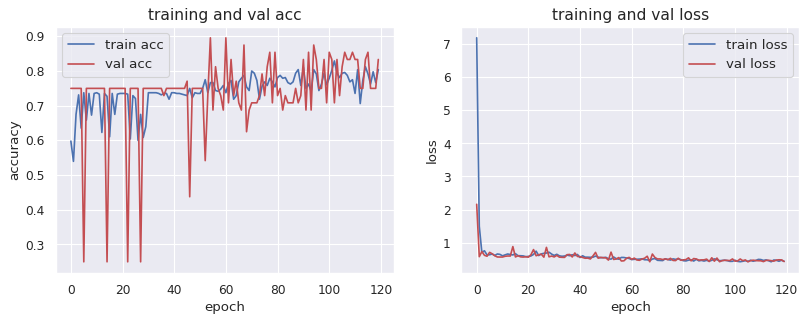

In [7]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(epochs):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)

    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)

    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)

    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()

In [8]:
model_save_path = '/content/drive/MyDrive/crp0.3_checkpoint'
torch.save(model.state_dict(), model_save_path)

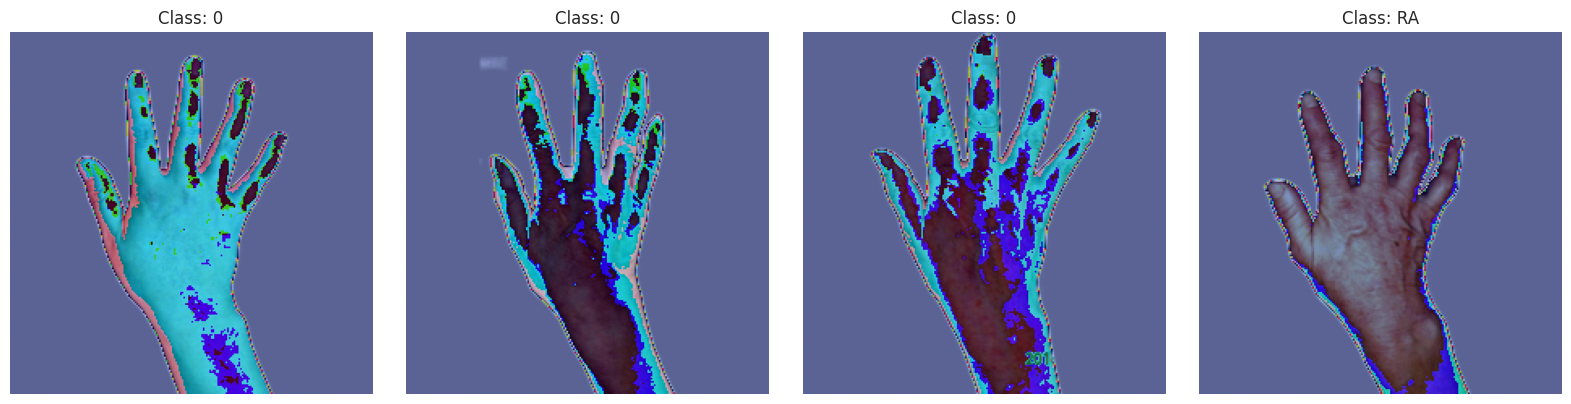

13387

In [9]:
class GradCam:
    def __init__(self, model, device):
        self.model = model
        self.feature = None
        self.gradient = None
        self.device = device

        def forward_hook(module, input, output):
            self.feature = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradient = grad_out[0].detach()

        # 最後のアテンションブロックを取得
        if hasattr(model, 'blocks'):
            target_layer = model.blocks[-1]
            target_layer.register_forward_hook(forward_hook)
            target_layer.register_full_backward_hook(backward_hook)
        else:
            raise ValueError("Unexpected model architecture")

    def __call__(self, x):
        self.feature = None
        self.gradient = None

        # 入力をデバイスに移動
        x = x.to(self.device)

        # 予測を実行
        output = self.model(x)
        pred_class = output.argmax(dim=1)

        # 予測クラスに対する勾配を計算
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, pred_class] = 1
        output.backward(gradient=one_hot)

        # 特徴量と勾配の処理
        feature_map = self.feature[:, 1:, :]  # CLSトークンを除外
        gradient_map = self.gradient[:, 1:, :]  # CLS トークンを除外

        # 重みの計算
        weights = gradient_map.mean(dim=2)  # [1, N]

        # CAMの計算
        batch_size = feature_map.shape[0]
        num_patches = feature_map.shape[1]
        patch_size = int(np.sqrt(num_patches))

        cam = torch.mul(feature_map, weights.unsqueeze(-1))
        cam = cam.mean(dim=2)  # [1, N]

        # パッチサイズに変形
        cam = cam.view(batch_size, patch_size, patch_size)

        # 正規化とReLU
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        # 元の画像サイズにリサイズ
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-7)

        return cam

def overlay_heatmap_to_image(image, heatmap):
    # 画像を[0, 255]の範囲に変換
    image = ((image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255).astype(np.uint8)

    # ヒートマップを[0, 255]の範囲に変換してカラーマップを適用
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    # 別のカラーマップを試す（例：COLORMAP_VIRIDISやCOLORMAP_INFERNO）
    #heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_INFERNO)

    # 画像とヒートマップを重ね合わせ
    alpha = 0.2
    overlayed = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)

    return overlayed / 255.0

# GradCAMのインスタンスを作成
grad_cam = GradCam(model, device)

# テストデータから画像を取得
images, labels = next(iter(test_loader))
images = images[:5]
labels = labels[:5]

# ヒートマップの生成と表示
plt.figure(figsize=(20, 4))

for i, (image, label) in enumerate(zip(images, labels)):
    try:
        # GradCAMを計算
        heatmap = grad_cam(image.unsqueeze(0))

        # ヒートマップをオーバーレイ
        overlayed = overlay_heatmap_to_image(image, heatmap)

        # 結果を表示
        plt.subplot(1, 5, i+1)
        plt.imshow(overlayed)
        plt.title(f'Class: {label.item()}')
        plt.axis('off')
    except Exception as e:
        print(f"Error processing image {i}: {str(e)}")

plt.title(f'Class: {"RA" if label.item() == 0 else "Non-RA"}')
plt.tight_layout()
plt.show()

# メモリの解放
torch.cuda.empty_cache()
gc.collect()